### 03 - HEAT STRESS OUTPUTS EXPLORATION

#### 03.1 - Libraries import

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### 03.2 - Temporal patterns analysis

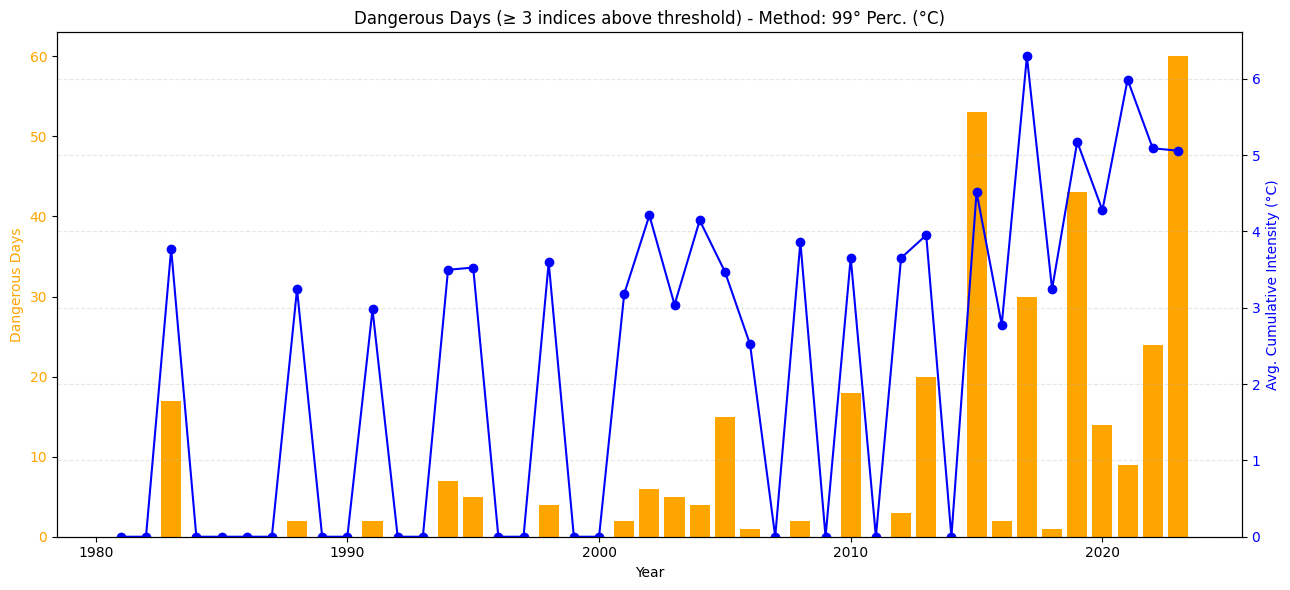

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========== PARAMETERS ==========
csv_path = "heatstress_all_timestamps_all_years.csv"
stat_method = "99° Perc. (°C)"  # Examples: "Mean (°C)", "Median (°C)", "95° Perc. (°C)", etc.
min_thresholds_exceeded = 3     # Minimum number of indices that must exceed threshold

# ========== LOAD DATA ==========
df = pd.read_csv(csv_path, parse_dates=["Timestamp"])
df["Year"] = df["Timestamp"].dt.year

# Dynamic column names
col_value = stat_method
col_threshold = "Soglia (°C)"
col_comparison = stat_method.replace(" (°C)", "") + " > Soglia"

# Check required columns
for col in [col_value, col_threshold, col_comparison]:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found. Available columns:\n{df.columns.tolist()}")

# ========== PROCESS DANGEROUS DAYS ==========
danger_days = []

for date, group in df.groupby("Timestamp"):
    group = group.set_index("Indice")
    bool_exceeded = group[col_comparison] == "si"
    n_exceeded = bool_exceeded.sum()
    
    # Excedance: summatory of the residuals between threshold and actual value for each of the parameters
    # for a day over "min_thresholds_exceeded"
    
    if n_exceeded >= min_thresholds_exceeded:
        exceedance_sum = (group.loc[bool_exceeded, col_value] - group.loc[bool_exceeded, col_threshold]).sum()
        danger_days.append({
            "Date": date,
            "Year": date.year,
            "ThresholdsExceeded": n_exceeded,
            "ExceedanceSum": exceedance_sum
        })

# ========== YEARLY AGGREGATION ==========
df_danger = pd.DataFrame(danger_days)
years_full = range(df["Year"].min(), df["Year"].max() + 1)

summary = df_danger.groupby("Year").agg({
    "Date": "count",
    "ExceedanceSum": "sum"
}).rename(columns={"Date": "DangerousDays"}).reindex(years_full, fill_value=0)

# Compute average cumulative intensity
summary["DangerousDays"] = summary["DangerousDays"].clip(lower=0).fillna(0)
summary["ExceedanceSum"] = summary["ExceedanceSum"].fillna(0)
summary["AvgCumulativeIntensity"] = summary.apply(
    lambda row: row["ExceedanceSum"] / row["DangerousDays"] if row["DangerousDays"] > 0 else 0,
    axis=1
)

# ========== PLOT ==========
fig, ax1 = plt.subplots(figsize=(13, 6))

# Bar plot: dangerous days per year
ax1.bar(summary.index, summary["DangerousDays"], color="orange", label="Dangerous Days")
ax1.set_ylabel("Dangerous Days", color="orange")
ax1.set_xlabel("Year")
ax1.tick_params(axis='y', labelcolor="orange")
ax1.set_ylim(bottom=0)  # Force bottom to zero

# Line plot: average cumulative intensity
ax2 = ax1.twinx()
ax2.plot(summary.index, summary["AvgCumulativeIntensity"], color="blue", marker='o', label="Avg. Cumulative Intensity")
ax2.set_ylabel("Avg. Cumulative Intensity (°C)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(bottom=0)  # Align zero with bar axis

plt.title(f"Dangerous Days (≥ {min_thresholds_exceeded} indices above threshold) - Method: {stat_method}")
plt.grid(True, axis="both", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()